In [4]:
# Install (if needed)
!pip install -q scikit-learn pandas matplotlib seaborn joblib

Loading data...
Variants: (3321, 4)
Text loaded: (3321, 2)
Final dataset: (3321, 5)
Preprocessing...
Training models...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Evaluating...

Classification Report:
              precision    recall  f1-score   support

     Class 1       0.52      0.52      0.52       114
     Class 2       0.64      0.48      0.55        91
     Class 3       0.40      0.44      0.42        18
     Class 4       0.71      0.53      0.61       137
     Class 5       0.32      0.46      0.38        48
     Class 6       0.85      0.51      0.64        55
     Class 7       0.68      0.82      0.74       191
     Class 8       0.00      0.00      0.00         4
     Class 9       0.56      0.71      0.62         7

    accuracy                           0.60       665
   macro avg       0.52      0.50      0.50       665
weighted avg       0.63      0.60      0.60       665

Macro F1-Score: 0.498
ROC-AUC: 0.823


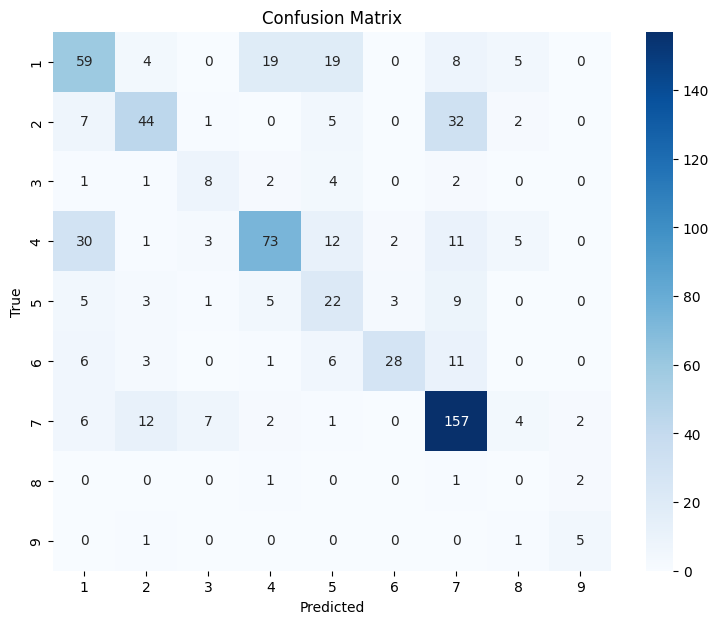

Model saved as 'model.pkl'


In [9]:
# ================================
# 1. FIX CSV PARSING (Handles malformed | in text)
# ================================
import csv
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from scipy.sparse import hstack, csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Increase field limit
csv.field_size_limit(1000000)

print("Loading data...")

# === SAFE LOAD: training_variants.csv ===
variants = pd.read_csv('/content/training_variants.csv')
print(f"Variants: {variants.shape}")

# === SAFE LOAD: training_text.csv (line-by-line) ===
def safe_load_text(path):
    data = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            # Split by '||' but keep everything after as text
            parts = line.split('||', 1)
            if len(parts) == 2:
                id_part, text = parts
                try:
                    id_val = int(id_part.split(',')[-1])  # ID is last in first part
                    data.append([id_val, text])
                except:
                    continue
            elif '||' not in line and ',' in line:
                # Fallback: assume ID is first column
                try:
                    id_val = int(line.split(',')[0])
                    data.append([id_val, line])
                except:
                    continue
    return pd.DataFrame(data, columns=['ID', 'Text'])

text = safe_load_text('/content/training_text.csv')
print(f"Text loaded: {text.shape}")

# Clean text
text['Text'] = text['Text'].fillna('').astype(str)

# Merge
df = pd.merge(variants, text, on='ID', how='left')
df['Text'] = df['Text'].fillna('')
print(f"Final dataset: {df.shape}")

# ================================
# 2. PREPROCESS
# ================================
print("Preprocessing...")
le_gene = LabelEncoder()
le_var = LabelEncoder()

df['Gene_encoded'] = le_gene.fit_transform(df['Gene'])
df['Variation_encoded'] = le_var.fit_transform(df['Variation'])

tfidf = TfidfVectorizer(
    max_features=8000,
    stop_words='english',
    ngram_range=(1,2),
    min_df=2,
    max_df=0.95
)
X_text = tfidf.fit_transform(df['Text'])
X_tab = df[['Gene_encoded', 'Variation_encoded']].values
X = hstack([csr_matrix(X_tab), X_text])
y = df['Class'] - 1

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ================================
# 3. TRAIN
# ================================
print("Training models...")
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
lr = LogisticRegression(
    multi_class='multinomial',
    max_iter=200,
    class_weight='balanced',
    n_jobs=-1
)

rf.fit(X_train, y_train)
lr.fit(X_train, y_train)

ensemble = VotingClassifier([('rf', rf), ('lr', lr)], voting='soft')
ensemble.fit(X_train, y_train)

# ================================
# 4. EVALUATE
# ================================
print("Evaluating...")
y_pred = ensemble.predict(X_test)
y_pred_proba = ensemble.predict_proba(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=[f"Class {i}" for i in range(1,10)]))

macro_f1 = f1_score(y_test, y_pred, average='macro')
y_test_bin = label_binarize(y_test, classes=range(9))
roc_auc = roc_auc_score(y_test_bin, y_pred_proba, average='macro', multi_class='ovr')

print(f"Macro F1-Score: {macro_f1:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")

# Confusion Matrix
plt.figure(figsize=(9,7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=range(1,10), yticklabels=range(1,10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ================================
# 5. SAVE
# ================================
joblib.dump(ensemble, 'model.pkl')
joblib.dump(le_gene, 'le_gene.pkl')
joblib.dump(le_var, 'le_variation.pkl')
joblib.dump(tfidf, 'tfidf.pkl')
print("Model saved as 'model.pkl'")